In [74]:
import typing as t
import numpy as np
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from pymorphy3 import MorphAnalyzer

nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\podov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\podov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [75]:
df = pd.read_csv('../storage/Petitions.csv', encoding='utf-8', sep=',')
df

,id,public_petition_text,reason_category
0,3168490,снег на дороге,Благоустройство
1,3219678,очистить кабельный киоск от рекламы,Благоустройство
2,2963920,"Просим убрать все деревья и кустарники, которы...",Благоустройство
3,3374910,Неудовлетворительное состояние парадной - надп...,Содержание МКД
4,3336285,Граффити,Благоустройство
...,...,...,...
59884,3128111,прошу закрасить граффити,Благоустройство
59885,3276713,Прошу вас отремонтировать пешеходную дорожку,Благоустройство
59886,3274663,Необходимо демонтировать незаконную рекламную ...,Незаконная информационная и (или) рекламная ко...
59887,3359308,Очень гремит на ветру металлическая часть окна...,Кровля


In [76]:
df.drop(columns=['id'], inplace=True)
df[:2]

,public_petition_text,reason_category
0,снег на дороге,Благоустройство
1,очистить кабельный киоск от рекламы,Благоустройство


In [80]:
corpus, ys = df['public_petition_text'].to_list(), df['reason_category'].to_list()

In [81]:
corpus, ys = corpus[:30000], ys[:30000]

In [82]:
def apply_re(pattern: str, reply_on: str, corpus: t.Sequence[str]) -> t.MutableSequence[str]:
    return list(map(lambda x: re.sub(pattern, reply_on, x), corpus))

In [83]:
corpus = apply_re('(<[^>]+>|\s)', ' ', corpus)
corpus = apply_re('ё', 'е', corpus)
corpus = apply_re(' ул(?=[\.\d ])', ' улица ', corpus)
corpus = apply_re(' (д|дом)(?=[\.\d ])', ' дом ', corpus)
corpus = apply_re(' (к|корп|корпус|кор)(?=[\.\d ])', ' корпус ', corpus)
corpus = apply_re(' (к|кв)(?=[\.\d])', ' квартира ', corpus)
corpus = apply_re('[^{а-яА-Яa-zA-Z0-9}]', ' ', corpus)
corpus = apply_re('(\d|( . ))', ' ', corpus)
corpus = apply_re('\s+', ' ', corpus)

corpus[:25]

['снег на дороге',
 'очистить кабельный киоск от рекламы',
 'Просим убрать все деревья кустарники которые вышли за пределы газона на пешеходную зону начиная от подъезда до подъезда фасад дома со стороны улица Наличной ',
 'Неудовлетворительное состояние парадной надписи на двери этажа',
 'Граффити',
 'Необходимо проверить законность установки вывески на фасаде МКД по адресу проспект Непокоренных случае если вывеска установлена незаконно ее необходимо демонтировать',
 'Уборка не производится на лестнице очень грязно На всех этажах вплоть до го Звонок ЖКС не дал результатов ',
 'Мусор',
 'Отсутствует освещение на лестничной площадке между и этажами парадной ',
 'Зачем было делать благоустройство если никто не убирает мусор так ежедневно ',
 'Просьба закрасить',
 'Реклама на заборе ',
 'Снег тротуаре не убран',
 'Проблема регулярным вывозом мусора',
 'Рисунки',
 'Пожалуйста удалите бетонный обрубок ржавой арматурой газона перед домом Адрес улица Тухачевского дом корпус ',
 'Мусор на асфал

In [84]:
morph = MorphAnalyzer()
stop_words = stopwords.words('russian')

corpus = [
    [
        word_norm for word in word_tokenize(doc, language='russian')
        if (word_norm := morph.normal_forms(word)[0]) not in stop_words
    ] for doc in corpus
]
# corpus = [
#     [
#         word for word in word_tokenize(doc, language='russian')
#     ] for doc in corpus
# ]

corpus[:5]

[['снег', 'дорога'],
 ['очистить', 'кабельный', 'киоск', 'реклама'],
 ['просить',
  'убрать',
  'всё',
  'дерево',
  'кустарник',
  'который',
  'выйти',
  'предел',
  'газон',
  'пешеходный',
  'зона',
  'начинать',
  'подъезд',
  'подъезд',
  'фасад',
  'дом',
  'сторона',
  'улица',
  'наличный'],
 ['неудовлетворительный', 'состояние', 'парадный', 'надпись', 'дверь', 'этаж'],
 ['граффити']]

In [85]:
idx2word = dict(enumerate(set().union(*corpus)))
word2idx = {v: k for k, v in idx2word.items()}

y2idx = dict(zip((y_uniq := set(ys)), range(len(y_uniq))))

voc_len = len(idx2word)
y_voc_len = len(y2idx)
voc_len, y_voc_len

(12548, 15)

In [9]:
y2idx

{'Подвалы': 0,
 'Водоснабжение': 1,
 'Повреждения или неисправность элементов уличной инфраструктуры': 2,
 'Нарушение порядка пользования общим имуществом': 3,
 'Состояние рекламных или информационных конструкций': 4,
 'Нарушение правил пользования общим имуществом': 5,
 'Содержание МКД': 6,
 'Центральное отопление': 7,
 'Водоотведение': 8,
 'Кровля': 9,
 'Незаконная информационная и (или) рекламная конструкция': 10,
 'Санитарное состояние': 11,
 'Незаконная реализация товаров с торгового оборудования (прилавок, ящик, с земли)': 12,
 'Фасад': 13,
 'Благоустройство': 14}

In [86]:
X_ = [[word2idx[word] for word in doc] for doc in corpus]
X_[3], ys[3]

([3778, 9061, 12437, 1989, 131, 5042], 'Содержание МКД')

In [87]:
y_ = list(y2idx[_] for _ in ys)
y_[:5]

[14, 14, 14, 6, 14]

In [50]:
from sklearn.model_selection import train_test_split

In [88]:
{k: y_.count(k) for k in y2idx.values()}

{0: 120,
 1: 419,
 2: 606,
 3: 117,
 4: 338,
 5: 1060,
 6: 7187,
 7: 138,
 8: 122,
 9: 393,
 10: 911,
 11: 222,
 12: 131,
 13: 775,
 14: 17461}

In [89]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

torch.cuda_version, torch.cuda.is_available(), torch.cuda.get_device_name(torch.cuda.current_device())

('11.8', True, 'NVIDIA GeForce GTX 1650')

In [90]:
X = nn.utils.rnn.pad_sequence([
    torch.tensor(x, dtype=torch.int64) for x in X_
], padding_value=voc_len).T  # batch first?
Y = torch.tensor(y_, dtype=torch.int64)

X.shape, Y.shape

(torch.Size([30000, 194]), torch.Size([30000]))

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, stratify=Y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([20100, 194]),
 torch.Size([9900, 194]),
 torch.Size([20100]),
 torch.Size([9900]))

In [92]:
X_train = X_train.cuda()
X_test = X_test.cuda()
y_train = y_train.cuda()
y_test = y_test.cuda()

In [93]:
train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=1024, shuffle=True)

## RNN

In [19]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, n_layers, y_label_size) -> None:
        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
        )
        self.rnn = nn.RNN(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, y_label_size),
        )

    def forward(self, inputs):
        y = self.embedding(inputs)

        # h0 = torch.zeros(self.n_layers, inputs.size(0), self.hidden_size)
        output, hidden = self.rnn(y)  #, h0)
        y = self.fc(hidden[-1])  # == hidden[0]
        return y

In [20]:
lr = 1e-3
loss = nn.CrossEntropyLoss()
rnn = RNN(voc_len + 1, 101, 99, 1, len(y2idx))
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)

rnn = rnn.cuda()
all(param.is_cuda for param in rnn.parameters())

True

In [21]:
epochs = 1

In [22]:
for epoch in range(epochs):
    print(f'[RNN] Epoch {epoch + 1}...')
    for x_b, y_b in train_dl:
        outputs = rnn(x_b)
        loss_value = loss(outputs, y_b)
        print(f'\tLoss value is {loss_value:.3f}.')
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

[RNN] Epoch 1...
	Loss value is 2.843.
	Loss value is 2.455.
	Loss value is 2.131.
	Loss value is 1.878.
	Loss value is 1.670.
	Loss value is 1.590.
	Loss value is 1.518.
	Loss value is 1.461.
	Loss value is 1.403.
	Loss value is 1.417.
	Loss value is 1.407.
	Loss value is 1.433.
	Loss value is 1.350.
	Loss value is 1.425.
	Loss value is 1.401.
	Loss value is 1.403.
	Loss value is 1.429.
	Loss value is 1.367.
	Loss value is 1.407.
	Loss value is 1.378.


In [23]:
rnn.rnn.all_weights

[[Parameter containing:
  tensor([[-0.0695,  0.0641,  0.0638,  ...,  0.0905,  0.0281,  0.0192],
          [-0.0019, -0.0058,  0.0822,  ...,  0.0877, -0.0696, -0.0730],
          [-0.0820, -0.0734, -0.0119,  ..., -0.0146, -0.1054, -0.0108],
          ...,
          [ 0.0174, -0.0964, -0.0367,  ..., -0.0646, -0.0618, -0.0446],
          [ 0.0074,  0.0738, -0.0568,  ...,  0.0154, -0.0882, -0.0773],
          [-0.0666,  0.0023, -0.0398,  ...,  0.0178, -0.0827, -0.0710]],
         device='cuda:0', requires_grad=True),
  Parameter containing:
  tensor([[-0.0481,  0.0082,  0.0131,  ...,  0.0259, -0.0223,  0.0180],
          [-0.0055, -0.0768,  0.0613,  ..., -0.0817,  0.0001, -0.0699],
          [ 0.0957,  0.0357,  0.1039,  ..., -0.0756, -0.1048,  0.0305],
          ...,
          [-0.0601, -0.0226, -0.0349,  ..., -0.0015,  0.0306, -0.0440],
          [ 0.0174, -0.0453, -0.0479,  ..., -0.0114,  0.1047,  0.0585],
          [ 0.0519,  0.0569, -0.0818,  ...,  0.0151, -0.0269, -0.0164]],
         

In [24]:
[w.shape for w in rnn.rnn.all_weights[0]]

[torch.Size([99, 101]),
 torch.Size([99, 99]),
 torch.Size([99]),
 torch.Size([99])]

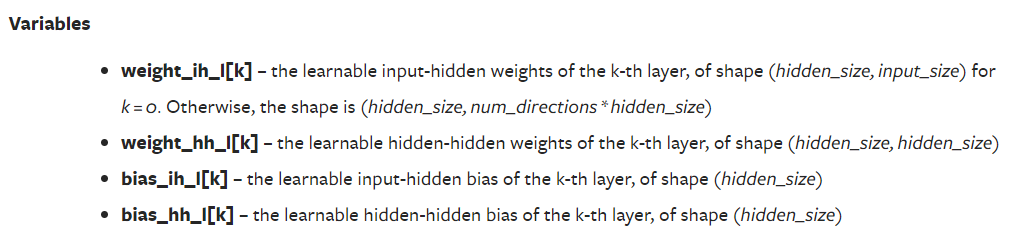

In [25]:
rnn.rnn.all_weights[0][1]  # ? брать [-1]? Тогда doc2vec = vector[100]  # Или перемножать матрицы с входом. Или output / h_n?
# hidden = doc2vec

Parameter containing:
tensor([[-0.0481,  0.0082,  0.0131,  ...,  0.0259, -0.0223,  0.0180],
        [-0.0055, -0.0768,  0.0613,  ..., -0.0817,  0.0001, -0.0699],
        [ 0.0957,  0.0357,  0.1039,  ..., -0.0756, -0.1048,  0.0305],
        ...,
        [-0.0601, -0.0226, -0.0349,  ..., -0.0015,  0.0306, -0.0440],
        [ 0.0174, -0.0453, -0.0479,  ..., -0.0114,  0.1047,  0.0585],
        [ 0.0519,  0.0569, -0.0818,  ...,  0.0151, -0.0269, -0.0164]],
       device='cuda:0', requires_grad=True)

In [26]:
rnn.rnn.all_weights[0][1].shape

torch.Size([99, 99])

In [158]:
rnn(X_test[:5])

tensor([[-1.1797, -1.2780,  0.1849, -0.5420, -0.9602, -0.8028,  3.1516, -1.5414,
         -1.1681, -0.6011, -1.3642, -0.1670,  2.5733, -1.4636, -1.7002],
        [-1.1797, -1.2780,  0.1849, -0.5420, -0.9602, -0.8028,  3.1516, -1.5414,
         -1.1681, -0.6011, -1.3642, -0.1670,  2.5733, -1.4636, -1.7002],
        [-1.1797, -1.2780,  0.1849, -0.5420, -0.9602, -0.8028,  3.1516, -1.5414,
         -1.1681, -0.6011, -1.3642, -0.1670,  2.5733, -1.4636, -1.7002],
        [-1.1797, -1.2780,  0.1849, -0.5420, -0.9602, -0.8028,  3.1516, -1.5414,
         -1.1681, -0.6011, -1.3642, -0.1670,  2.5733, -1.4636, -1.7002],
        [-1.1797, -1.2780,  0.1849, -0.5420, -0.9602, -0.8028,  3.1516, -1.5414,
         -1.1681, -0.6011, -1.3642, -0.1670,  2.5733, -1.4636, -1.7002]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [35]:
from sklearn.metrics import classification_report


seq = nn.Sequential(
    # nn.Linear(y_voc_len, y_voc_len),
    nn.Softmax(),
).cuda()

y_pred = torch.argmax(seq(rnn(X_test[:500])), dim=1)

print(classification_report(
    y_pred.cpu().detach().numpy(),
    y_test[:500].cpu().detach().numpy(),
))

## LSTM

In [41]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, n_layers, y_label_size) -> None:
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
        )
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_size, y_label_size)


    def forward(self, inputs):
        y = self.embedding(inputs)
        output, (h_n, c_n) = self.lstm(y)
        y = self.fc(h_n[0])
        return y

In [42]:
lr = 1e-3
loss = nn.CrossEntropyLoss()
lstm = LSTM(voc_len + 1, 101, 99, 1, y_voc_len)
optimizer = torch.optim.Adam(lstm.parameters(), lr=lr)

lstm = lstm.cuda()
all(param.is_cuda for param in lstm.parameters())

True

In [43]:
epochs = 1

In [53]:
for epoch in range(epochs):
    print(f'[LSTM] Epoch {epoch + 1}...')
    for x_b, y_b in train_dl:
        outputs = lstm(x_b)
        loss_value = loss(outputs, y_b)
        print(f'\tLoss value is {loss_value:.3f}.')
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

[LSTM] Epoch 1...
	Loss value is 1.404.
	Loss value is 1.395.
	Loss value is 1.401.
	Loss value is 1.392.
	Loss value is 1.397.
	Loss value is 1.372.
	Loss value is 1.378.
	Loss value is 1.426.
	Loss value is 1.418.
	Loss value is 1.434.
	Loss value is 1.411.
	Loss value is 1.389.
	Loss value is 1.397.
	Loss value is 1.433.
	Loss value is 1.331.
	Loss value is 1.402.
	Loss value is 1.405.
	Loss value is 1.388.
	Loss value is 1.387.
	Loss value is 1.375.


In [54]:
[w.shape for w in lstm.lstm.all_weights[0]]

[torch.Size([396, 101]),
 torch.Size([396, 99]),
 torch.Size([396]),
 torch.Size([396])]

In [55]:
y_pred = torch.argmax(seq(lstm(X_test[:500])), dim=1)

print(classification_report(
    y_test[:500].cpu().detach().numpy(),
    y_pred.cpu().detach().numpy(),
))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00       127
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         1
           7       0.57      1.00      0.72       283
           8       0.00      0.00      0.00        17
           9       0.00      0.00      0.00         6
          10       0.00      0.00      0.00        17
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00        18

    accuracy                           0.57       500
   macro avg       0.04      0.07      0.05       500
weighted avg       0.32   

c:\Users\podov\Desktop\Andrey\Универ\Обработка естественного языка\5сем\nlp-labs\venv\Lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
c:\Users\podov\Desktop\Andrey\Универ\Обработка естественного языка\5сем\nlp-labs\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\podov\Desktop\Andrey\Универ\Обработка естественного языка\5сем\nlp-labs\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

## GRU

In [57]:
class GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, n_layers, y_label_size) -> None:
        super(GRU, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
        )
        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_size, y_label_size)


    def forward(self, inputs):
        y = self.embedding(inputs)
        output, h_n = self.gru(y)
        y = self.fc(h_n[0])
        return y

In [108]:
lr = 1e-3
loss = nn.CrossEntropyLoss()
gru = GRU(voc_len + 1, 256, 100, 2, y_voc_len)
optimizer = torch.optim.Adam(gru.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

gru = gru.cuda()
all(param.is_cuda for param in gru.parameters())

True

In [100]:
epochs = 5

In [111]:
for epoch in range(epochs):
    print(f'[GRU] Epoch {epoch + 1}...')
    for x_b, y_b in train_dl:
        outputs = gru(x_b)
        loss_value = loss(outputs, y_b)
        print(f'\tLoss value is {loss_value:.3f}.')
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

[GRU] Epoch 1...
	Loss value is 1.214.
	Loss value is 1.253.
	Loss value is 1.241.
	Loss value is 1.298.
	Loss value is 1.293.
	Loss value is 1.300.
	Loss value is 1.199.
	Loss value is 1.245.
	Loss value is 1.222.
	Loss value is 1.288.
	Loss value is 1.204.
	Loss value is 1.299.
	Loss value is 1.110.
	Loss value is 1.247.
	Loss value is 1.171.
	Loss value is 1.242.
	Loss value is 1.232.
	Loss value is 1.172.
	Loss value is 1.180.
	Loss value is 1.196.
[GRU] Epoch 2...
	Loss value is 1.163.
	Loss value is 1.179.
	Loss value is 1.118.
	Loss value is 1.169.
	Loss value is 1.138.
	Loss value is 1.157.
	Loss value is 1.181.
	Loss value is 1.168.
	Loss value is 1.138.
	Loss value is 1.143.
	Loss value is 1.168.
	Loss value is 1.094.
	Loss value is 1.131.
	Loss value is 1.116.
	Loss value is 1.196.
	Loss value is 1.058.
	Loss value is 1.121.
	Loss value is 1.165.
	Loss value is 1.201.
	Loss value is 1.119.
[GRU] Epoch 3...
	Loss value is 1.165.
	Loss value is 1.069.
	Loss value is 1.155.
	Lo

In [72]:
[w.shape for w in gru.gru.all_weights[0]]

[torch.Size([300, 256]),
 torch.Size([300, 100]),
 torch.Size([300]),
 torch.Size([300])]

In [112]:
y_pred = torch.argmax(seq(gru(X_test[:500])), dim=1)

print(classification_report(
    y_pred.cpu().detach().numpy(),
    y_test[:500].cpu().detach().numpy(),
))

c:\Users\podov\Desktop\Andrey\Универ\Обработка естественного языка\5сем\nlp-labs\venv\Lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.41      1.00      0.58         9
           6       0.88      0.66      0.75       156
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.98      0.86      0.91       335

    accuracy                           0.80       500
   macro avg       0.15      0.17      0.15       500
weighted avg       0.94   

c:\Users\podov\Desktop\Andrey\Универ\Обработка естественного языка\5сем\nlp-labs\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\podov\Desktop\Andrey\Универ\Обработка естественного языка\5сем\nlp-labs\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\podov\Desktop\Andrey\Универ\Обработка естественного языка\5сем\nlp-labs\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `ze